In [34]:
import spikeinterface.full as si
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from probeinterface.plotting import plot_probe

In [35]:

base_folder = Path(r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\dual_strd_hpc\seq008_2024-11-11_14-46-19\\")

# extract the stream names (each np processor)
stream_names, stream_ids = si.get_neo_streams('openephysbinary', base_folder)
print(stream_names)

['Record Node 103#NI-DAQmx-102.PXIe-6341', 'Record Node 103#Neuropix-PXI-100.ProbeA', 'Record Node 103#Neuropix-PXI-100.ProbeB']


(<matplotlib.collections.PolyCollection at 0x3a3bf5b23d0>,
 <matplotlib.collections.PolyCollection at 0x3a3bf567710>)

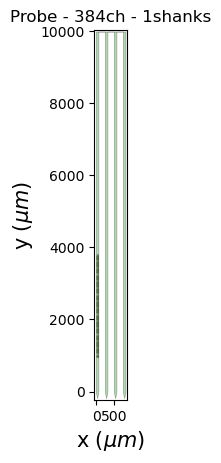

In [36]:
# load in probe A 
raw_rec = si.read_openephys(base_folder,stream_name = stream_names[1],load_sync_channel=False)
raw_rec.get_probe().to_dataframe()
# fig, ax = plt.subplots(figsize=(15, 10))
# si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=True)
# # ax.set_ylim(1000, 1300)

probe = raw_rec.get_probe()
plot_probe(probe)

Preprocess the recording¶
Let’s do something similar to the IBL destriping chain (See :ref:ibl_destripe) to preprocess the data but:

instead of interpolating bad channels, we remove then.

instead of highpass_spatial_filter() we use common_reference()

In [20]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4
rec

bad_channel_ids []


CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 440,454,525 samples 
                          14,681.82s (4.08 hours) - int16 dtype - 315.04 GiB

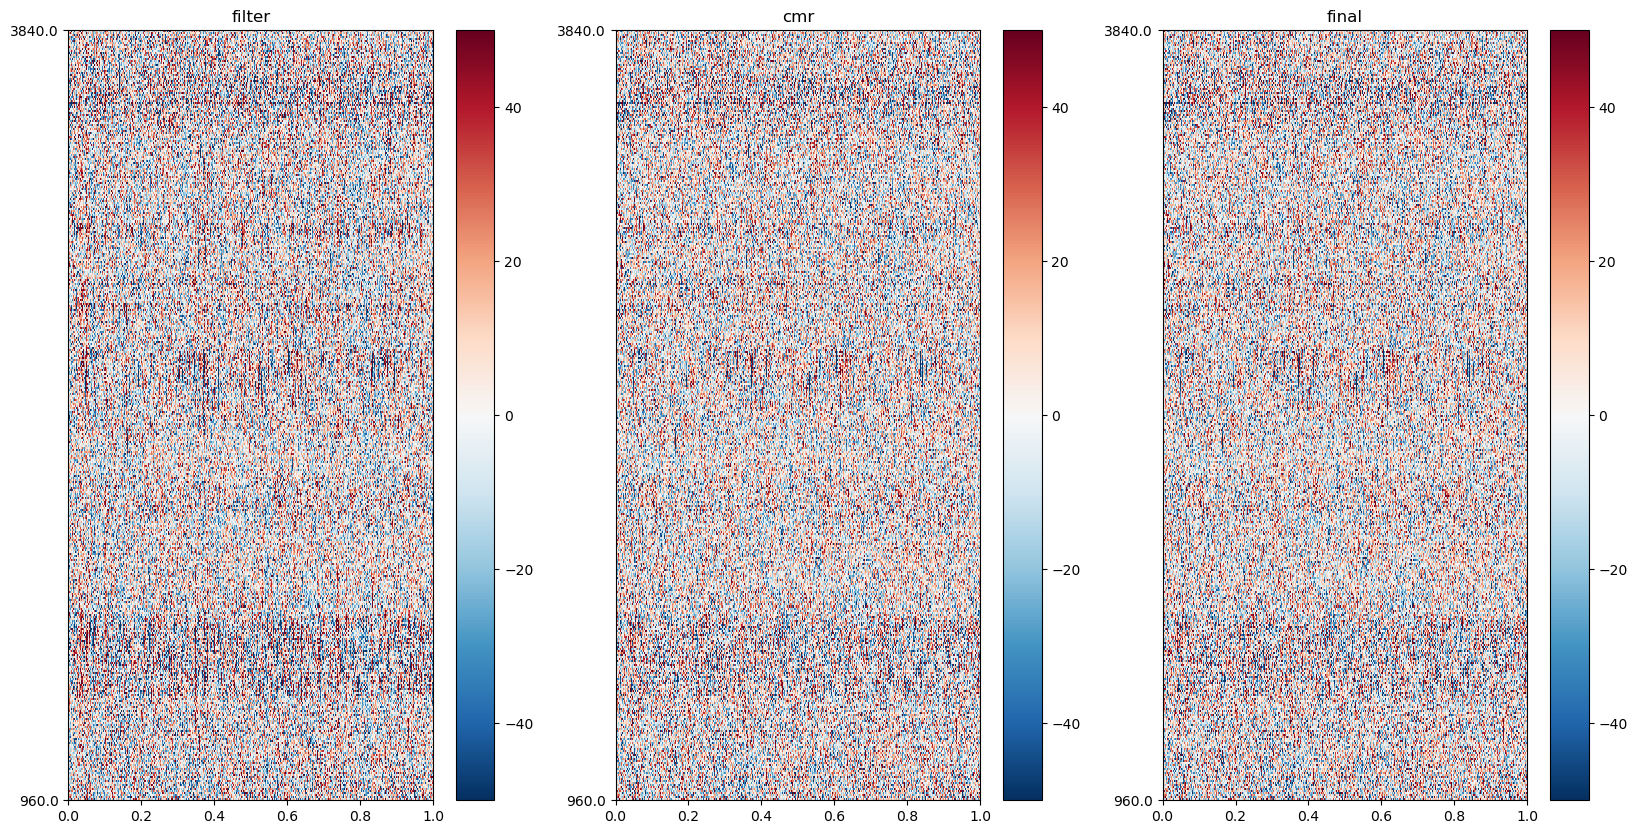

In [21]:
# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

si.plot_traces(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(rec, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)

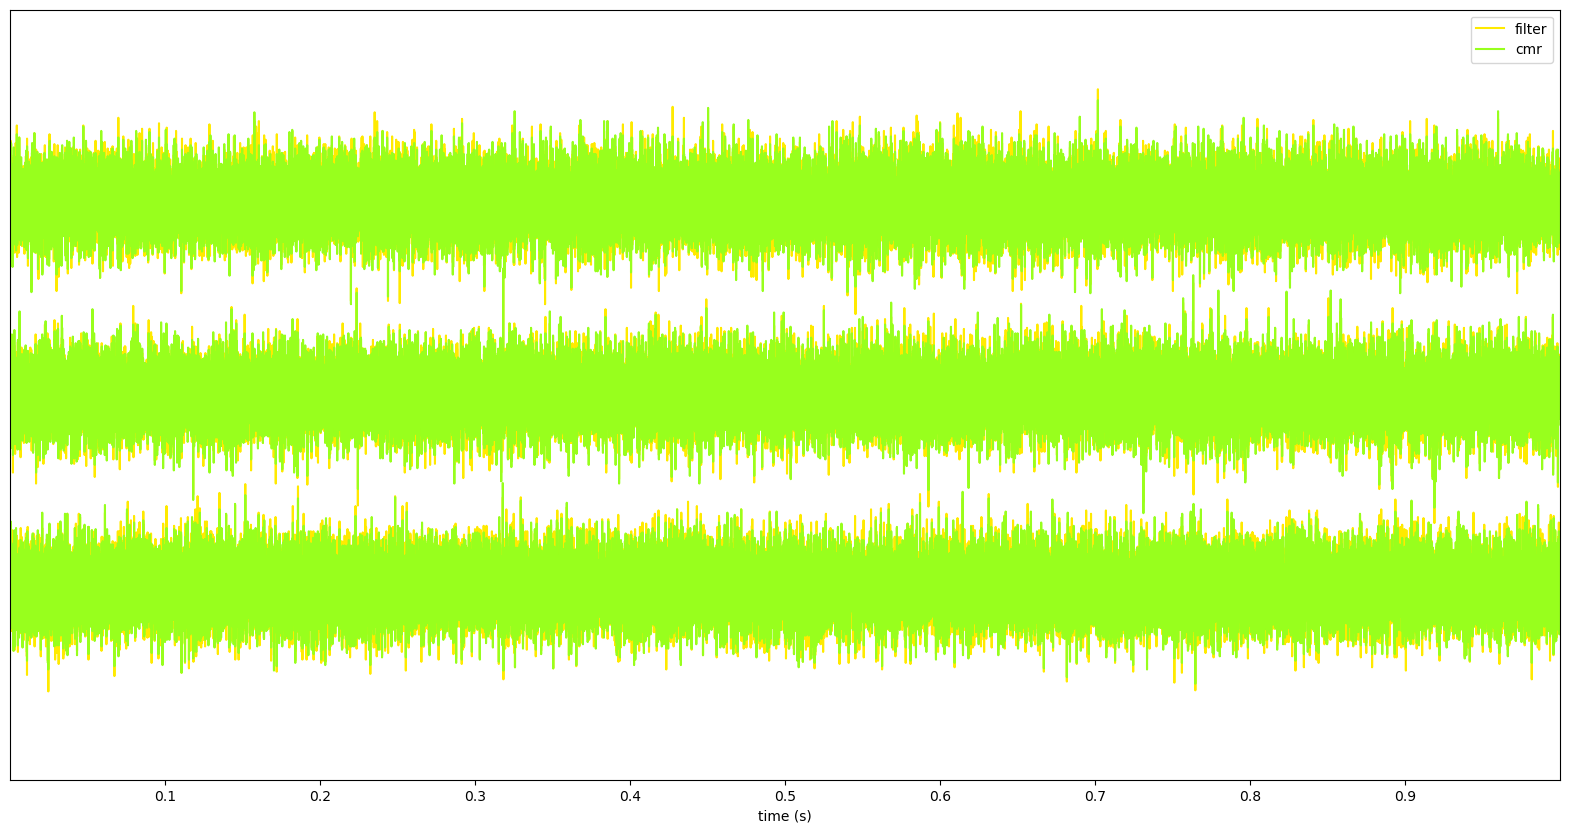

In [22]:
# plot some channels
fig, ax = plt.subplots(figsize=(20, 10))
some_chans = rec.channel_ids[[100, 150, 200, ]]
si.plot_traces({'filter':rec1, 'cmr': rec4}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

In [25]:
## save out the preprocessed binary

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

rec = rec.save(folder=base_folder / 'preprocess', format='binary', **job_kwargs)

write_binary_recording 
n_jobs=8 - samples_per_chunk=30,000 - chunk_memory=21.97 MiB - total_memory=175.78 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/14682 [00:00<?, ?it/s]

In [28]:
# check noise 
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec, return_scaled=False)

Text(0.5, 0, 'noise  [microV]')

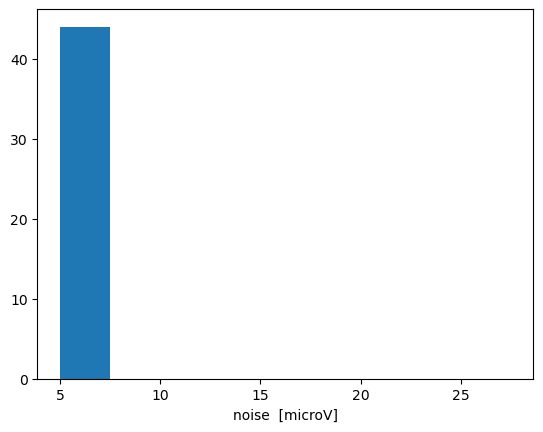

In [29]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')

## I think anything under 20uV is okay... not sure though, that is a guess 

In [12]:
# # find peaks

# from spikeinterface.sortingcomponents.peak_detection import detect_peaks
# from spikeinterface.sortingcomponents.peak_localization import localize_peaks
# break
# job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,
#                      detect_threshold=5, radius_um=50., **job_kwargs)

# peak_locations = localize_peaks(rec, peaks, method='center_of_mass', radius_um=50., **job_kwargs)



SyntaxError: 'break' outside loop (3566307101.py, line 5)

In [ ]:
# # check for drifts
# fs = rec.sampling_frequency
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

In [53]:
params_kilosort4

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'do_CAR': True,
 'invert_sign': False,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': None,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': None,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'x_centers': None,
 'duplicate_spike_ms': 0.25,
 'scaleproc': None,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'save_extra_vars': False,
 'do_correction': True,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'use_binary_file': None,
 'del

In [31]:
# check default params for kilosort2.5
params_kilosort4 = si.get_default_sorter_params('kilosort4')

# # run kilosort2.5 without drift correction
# params_kilosort2_5 = {'do_correction': False}

sorting = si.run_sorter('kilosort4', rec, output_folder=base_folder / 'kilosort4_output',
                        docker_image=False, verbose=True, **params_kilosort4)

C:\Users\Emmett\AppData\Local\Temp\ipykernel_16304\2294296539.py:7: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  sorting = si.run_sorter('kilosort4', rec, output_folder=base_folder / 'kilosort4_output',
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing preprocessing variables.
INFO:kilosort.run_kilosort:----------------------------------------
INFO:kilosort.run_kilosort:N samples: 440454525
INFO:kilosort.run_kilosort:N seconds: 14681.8175
INFO:kilosort.run_kilosort:N batches: 7341
INFO:kilosort.run_kilosort:Preprocessing filters computed in  189.15s; total  189.17s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Resource usage after preprocessing
INFO:kilosort.run_kilosort:********************************************************
INFO:kilosort.run_kilosort:CPU usage:    59.60 %
INFO:kilosort.run_kilosort:Memory:       11.63 %     |      7.41   /    63.71 GB
INFO:kilosort.run_kilosort:--------

kilosort4 run time 26892.33s


# Load back in to check quality 

In [38]:
# load the data back in 
sorting = si.read_sorter_folder(base_folder / 'kilosort4_output')

In [40]:
analyzer = si.create_sorting_analyzer(sorting, rec, sparse=True, format="memory")
analyzer

C:\Users\Emmett\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_sparsity:   0%|          | 0/14682 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 356 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions

In [41]:
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms",  ms_before=1.5,ms_after=2., **job_kwargs)
analyzer.compute("templates", operators=["average", "median", "std"])
analyzer.compute("noise_levels")
analyzer

compute_waveforms:   0%|          | 0/14682 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 356 units - 1 segments - memory - sparse - has recording
Loaded 4 extensions: random_spikes, waveforms, templates, noise_levels

In [42]:
analyzer_saved = analyzer.save_as(folder=base_folder / "analyzer", format="binary_folder")


In [43]:
# quality metrics 

In [44]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


# metrics = analyzer.compute("quality_metrics").get_data()
# equivalent to
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)

metrics

C:\Users\Emmett\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,amplitude_cutoff
0,2.06766,0.983607,2.156246,5.724791,1078,0.00309
1,1.276477,0.897541,1.117945,10.729112,770,0.0067
2,0.781851,1.0,4.024969,0.408548,11,0.005223
3,1.764291,1.0,1.848011,3.078016,422,0.001179
4,2.985189,1.0,3.531435,0.030573,12,0.000694
...,...,...,...,...,...,...
351,1.075003,1.0,4.915325,0.176816,9,0.001501
352,1.342204,1.0,2.708582,0.919993,73,0.000756
353,2.283096,1.0,2.799555,0.688189,158,0.000905
354,7.896229,1.0,4.028388,0.102685,282,0.083223


In [45]:
amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 1
presence_ratio_thresh = 0.9

our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"
print(our_query)

(amplitude_cutoff < 0.1) & (isi_violations_ratio < 1) & (presence_ratio > 0.9)


In [47]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
len(keep_unit_ids)

123

In [48]:
analyzer_clean = analyzer.select_units(keep_unit_ids, folder=base_folder / 'analyzer_clean', format='binary_folder')

In [49]:
# export spike sorting report to a folder
si.export_report(analyzer_clean, base_folder / 'report', format='png')

C:\Users\Emmett\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


export_report(): spike_amplitudes will not be exported. Use sorting_analyzer.compute('spike_amplitudes') if you want to include them.
export_report(): correlograms will not be exported. Use sorting_anlyzer.compute('correlograms') if you want to include them.


In [50]:
analyzer_clean = si.load_sorting_analyzer(base_folder / 'analyzer_clean')